In [5]:
#@title Imports
import random
import numpy as np

from deap import algorithms
from deap import base
from deap import creator
from deap import tools

import os
import ssl
import cv2
import urllib.request
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [6]:
#@title Image Helpers
ssl._create_default_https_context = ssl._create_unverified_context
def load_target_image(image_url, color=True, size=None):
  image_path = "target_image"
  urllib.request.urlretrieve(image_url,image_path)
  if color:
      target = cv2.imread(image_path, cv2.IMREAD_COLOR)
      # Switch from bgr to rgb
      target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)
  else:
      target = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

  if size:
      # Only resizes image if it is needed!
      target = cv2.resize(src=target, dsize=size, interpolation=cv2.INTER_AREA)
  return target

def show_image(img_arr):
    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.imshow(img_arr/255)
    plt.show()

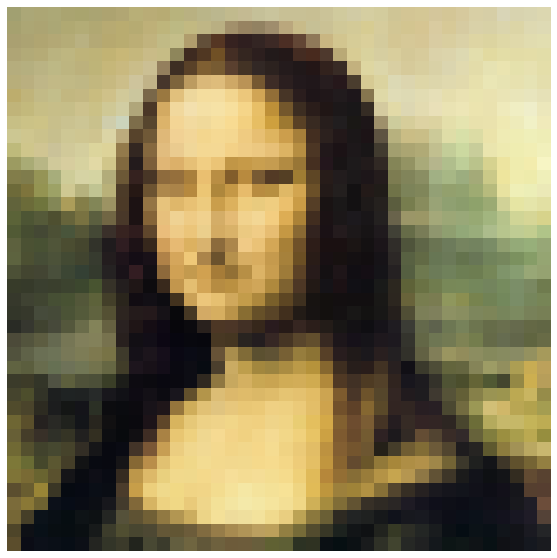

(40, 40, 3)


In [7]:
#@title Default title text { run: "auto" }
polygons = 128 #@param {type:"slider", min:10, max:1000, step:1}
size = 40 #@param {type:"slider", min:25, max:1000, step:5}
target_image = "Mona Lisa" #@param ["Mona Lisa", "Stop Sign", "Landscape", "Celebrity", "Art", "Abstract"]


POLYGONS = polygons
SIZE = (size, size)

target_urls = { "Mona Lisa" : 'https://upload.wikimedia.org/wikipedia/commons/b/b7/Mona_Lisa_face_800x800px.jpg',
               "Stop Sign" : 'https://images.uline.com/is/image//content/dam/images/H/H2500/H-2381.jpg',
               "Landscape" : 'https://www.adorama.com/alc/wp-content/uploads/2018/11/landscape-photography-tips-yosemite-valley-feature.jpg',
               "Celebrity" : 'https://s.abcnews.com/images/Entertainment/WireAP_91d6741d1954459f9993bd7a2f62b6bb_16x9_992.jpg',
               "Art" : "http://www.indianruminations.com/wp-content/uploads/what-is-modern-art-definition-2.jpg",
               "Abstract" : "https://scx2.b-cdn.net/gfx/news/2020/abstractart.jpg"
               }

target_image_url = target_urls[target_image]
target = load_target_image(target_image_url, size=SIZE)
show_image(target)
print(target.shape)

In [8]:
#@title Setup Polylines

#polygon genes
GENE_LENGTH = 10
NUM_GENES = POLYGONS * GENE_LENGTH

#create a sample invidiual
individual = np.random.uniform(0,1,NUM_GENES)
print(individual)

[0.32835348 0.03943193 0.2351134  ... 0.97576072 0.47195608 0.44242999]


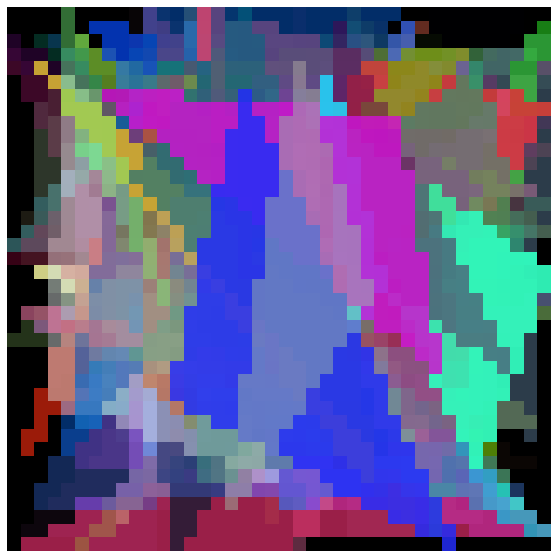

In [9]:
#@title Render an Individual
def extract_genes(genes, length):
    for i in range(0, len(genes), length):
        yield genes[i:i + length]

def render_individual(individual):
  if isinstance(individual,list):
    individual = np.array(individual)
  canvas = np.zeros(SIZE+(3,))
  radius_avg = (SIZE[0] + SIZE[1]) / 2 / 6
  genes = extract_genes(individual, GENE_LENGTH)
  for gene in genes:
    try:
      overlay = canvas.copy()
      # alternative drawing methods circle or rectangle
      # circle brush uses a GENE_LENGTH of 7
      # center = (0, 1) [2]
      # radius = (2) [3]
      # color = (3,4,5) [6]
      # alpha = (6) [7]
      #cv2.circle(
      #    overlay,
      #    center=(int(gene[1] * SIZE[1]), int(gene[0] * SIZE[0])),
      #    radius=int(gene[2] * radius_avg),
      #    color=color,
      #    thickness=-1,
      #)

      # rectangle brush uses GENE_LENGTH = 8
      # top left = (0, 1) [2]
      # btm right = (2, 3) [4]
      # color = (4, 5, 6) [7]
      # alpha = (7) [8]
      #cv2.rectangle(overlay, (x1, y1), (x2, y2), color, -1)

      # polyline brush uses GENE_LENGTH = 10
      # pts = (0, 1), (2, 3), (4, 5) [6]
      # color = (6, 7, 8) [9]
      # alpha = (9) [10]
      x1 = int(gene[0] * SIZE[0])
      x2 = int(gene[2] * SIZE[0])
      x3 = int(gene[4] * SIZE[0])
      y1 = int(gene[1] * SIZE[1])
      y2 = int(gene[3] * SIZE[1])
      y3 = int(gene[5] * SIZE[1])
      color = (gene[6:-1] * 255).astype(int).tolist()
      pts = np.array([[x1,y1],[x2,y2],[x3,y3]], np.int32)
      pts = pts.reshape((-1, 1, 2))
      pts = np.array([[x1,y1],[x2,y2],[x3,y3]])

      cv2.fillPoly(overlay, [pts], color)
      alpha = gene[-1]
      canvas = cv2.addWeighted(overlay, alpha, canvas, 1 - alpha, 0)
    except:
      pass
  return canvas

render = render_individual(individual)
show_image(render)

In [10]:
from skimage.metrics import structural_similarity as ss
#@title Fitness Function
def fitness_mse(render):
  """Calculates Mean Square Error Fitness for a render"""
  error = (np.square(render - target)).mean(axis=None)
  return error

def fitness_ss(render):
  """Calculated Structural Similiarity Fitness"""
  index = ss(render, target, multichannel=True)
  return 1-index

print(fitness_mse(render))

11336.808039177991


In [11]:
#@title Setting up the Creator
creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

In [12]:
def uniform(low, up, size=None):
  try:
    return [random.uniform(a, b) for a, b in zip(low, up)]
  except TypeError:
    return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

toolbox = base.Toolbox()
toolbox.register("attr_float", uniform, 0, 1, NUM_GENES)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [13]:
def evaluate(individual):
  render = render_individual(individual)
  print('.', end='')
  return fitness_mse(render),  #using MSE for fitness

In [14]:
#@title Register the Choices
def register_selection(choice):
  choices = ["Tournament", "Roulette", "Random", "Best", "Worst", "NSGA2", "SPEA2"]
  if choice == choices[0]:
    toolbox.register("select", tools.selTournament, tournsize=3)
  elif choice == choices[1]:
    toolbox.register("select", tools.selRoulette)
  elif choice == choices[2]:
    toolbox.register("select", tools.selRandom)
  elif choice == choices[3]:
    toolbox.register("select", tools.selBest)
  elif choice == choices[4]:
    toolbox.register("select", tools.selWorst)
  elif choice == choices[5]:
    toolbox.register("select", tools.selNSGA2)
  elif choice == choices[6]:
    toolbox.register("select", tools.selSPEA2)

def register_mating(choice):
  choices = ["Partially Matched", "One Point", "Two Point", "Ordered", "ES Two Point", "Uniform", "Uniform Partially Matched"]
  if choice == choices[0]:
    toolbox.register("mate", tools.cxPartialyMatched)
  elif choice == choices[1]:
    toolbox.register("mate", tools.cxOnePoint)
  elif choice == choices[2]:
    toolbox.register("mate", tools.cxTwoPoint)
  elif choice == choices[3]:
    toolbox.register("mate", tools.cxOrdered)
  elif choice == choices[4]:
    toolbox.register("mate", tools.cxESTwoPoint)
  elif choice == choices[5]:
    toolbox.register("mate", tools.cxUniform, indpb=.5)
  elif choice == choices[6]:
    toolbox.register("mate", tools.cxUniformPartialyMatched, indpb=.5)

In [15]:
#@title Selecting the Genetic Operators { run: "auto" }
selection = "Tournament" #@param ["Tournament", "Random", "Best", "Worst", "NSGA2", "SPEA2"]
mating = "One Point" #@param ["Partially Matched", "One Point", "Two Point", "Ordered", "Uniform", "Uniform Partially Matched"]

register_mating(mating)
register_selection(selection)

In [16]:
#@title Mutation and Evaluation
toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=1, indpb=.05)
toolbox.register("evaluate", evaluate)

In [17]:
random.seed(64)

NGEN = 100000
CXPB = .6
MUTPB = .3
MU = 2500
pop = toolbox.population(n=MU)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

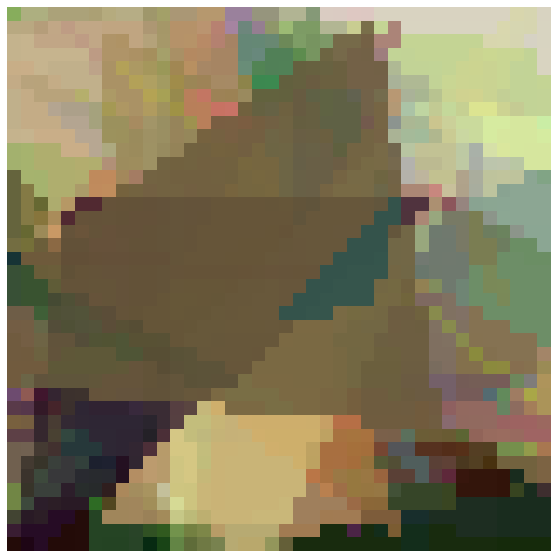

Gen (371) : fitness = 2144.9182920884864
...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

KeyboardInterrupt: 

In [18]:
best = None

for g in range(NGEN):
  pop, logbook = algorithms.eaSimple(pop, toolbox,
            cxpb=CXPB, mutpb=MUTPB, ngen=1, stats=stats, halloffame=hof, verbose=False)
  best = hof[0]
  clear_output()
  render = render_individual(best)
  show_image(render)
  print(f"Gen ({g}) : fitness = {fitness_mse(render)}")